In [1]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.stats
from autograd import grad
import scipy.ndimage
import cca

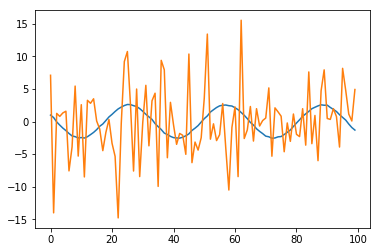

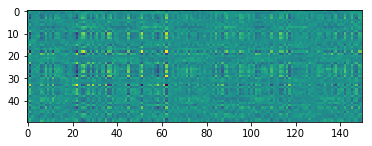

14.842059528154651


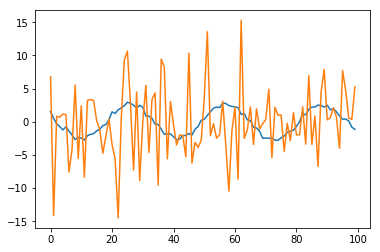

In [20]:
N = 50
len_X = 100000
d = 2
T = 20

E = scipy.stats.ortho_group.rvs(N)[:, :d]
dynamics = np.zeros((len_X, d))
t = np.arange(len_X)*0.2
for i in range(d):
    a, b = np.random.normal(0, 1, (2,))
    dynamics[:, i] = a*np.sin(t) + b*np.cos(t)
dynamics = dynamics + np.random.normal(0, 0.05, dynamics.shape)
dynamics[:, 1] = np.random.normal(0, 5, (len_X,))

plt.plot(dynamics[:100,:])
plt.show()

X = np.dot(dynamics, E.T)
X = X + np.random.normal(0, 0.3, X.shape)

plt.imshow(X[:3*N, :].T)
plt.show()

plt.plot(np.dot(X, E[:, :d])[:100])
print(cca.calc_pi(np.dot(X, E[:, :d]), T))

plt.show()

0.005931640282139808
14.849713866893435
14.860670495727089


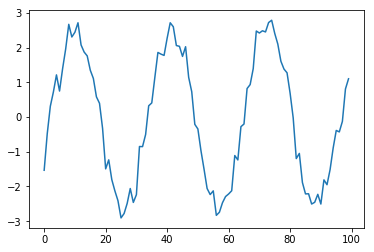

In [22]:
from imp import reload
reload(cca)

V_opt = cca.run_cca(X, T, 1, init="random")
X_proj = np.dot(X, V_opt)

plt.plot(X_proj[:100])

w, V = cca.pca(X)
print(cca.calc_pi(np.dot(X, V[:, :1]), T))
print(cca.calc_pi(np.dot(X, E[:, :1]), T))
print(cca.calc_pi(X_proj, T))

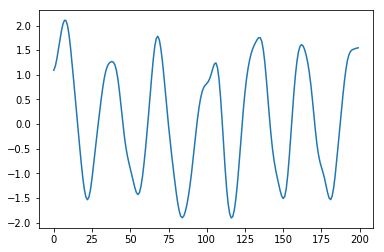

In [7]:
plt.plot(scipy.ndimage.gaussian_filter1d(X_proj[:200], sigma=3, axis=0))

In [32]:
np.dot(V_opt.T, V_opt)

array([[1.        , 0.62335638],
       [0.62335638, 1.        ]])